In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
fpath = "../../data/DNN_data/"

sig_with_artifact = np.load(fpath + "data_signal_with_sine_regular_pattern" + ".npy")
sig = np.load(fpath + "data_signal" + ".npy")
artifact = sig_with_artifact - sig

print(sig_with_artifact.shape)
print(sig.shape)

(1000, 4000)
(1000, 4000)


Text(0.5, 1.0, 'Original Signal')

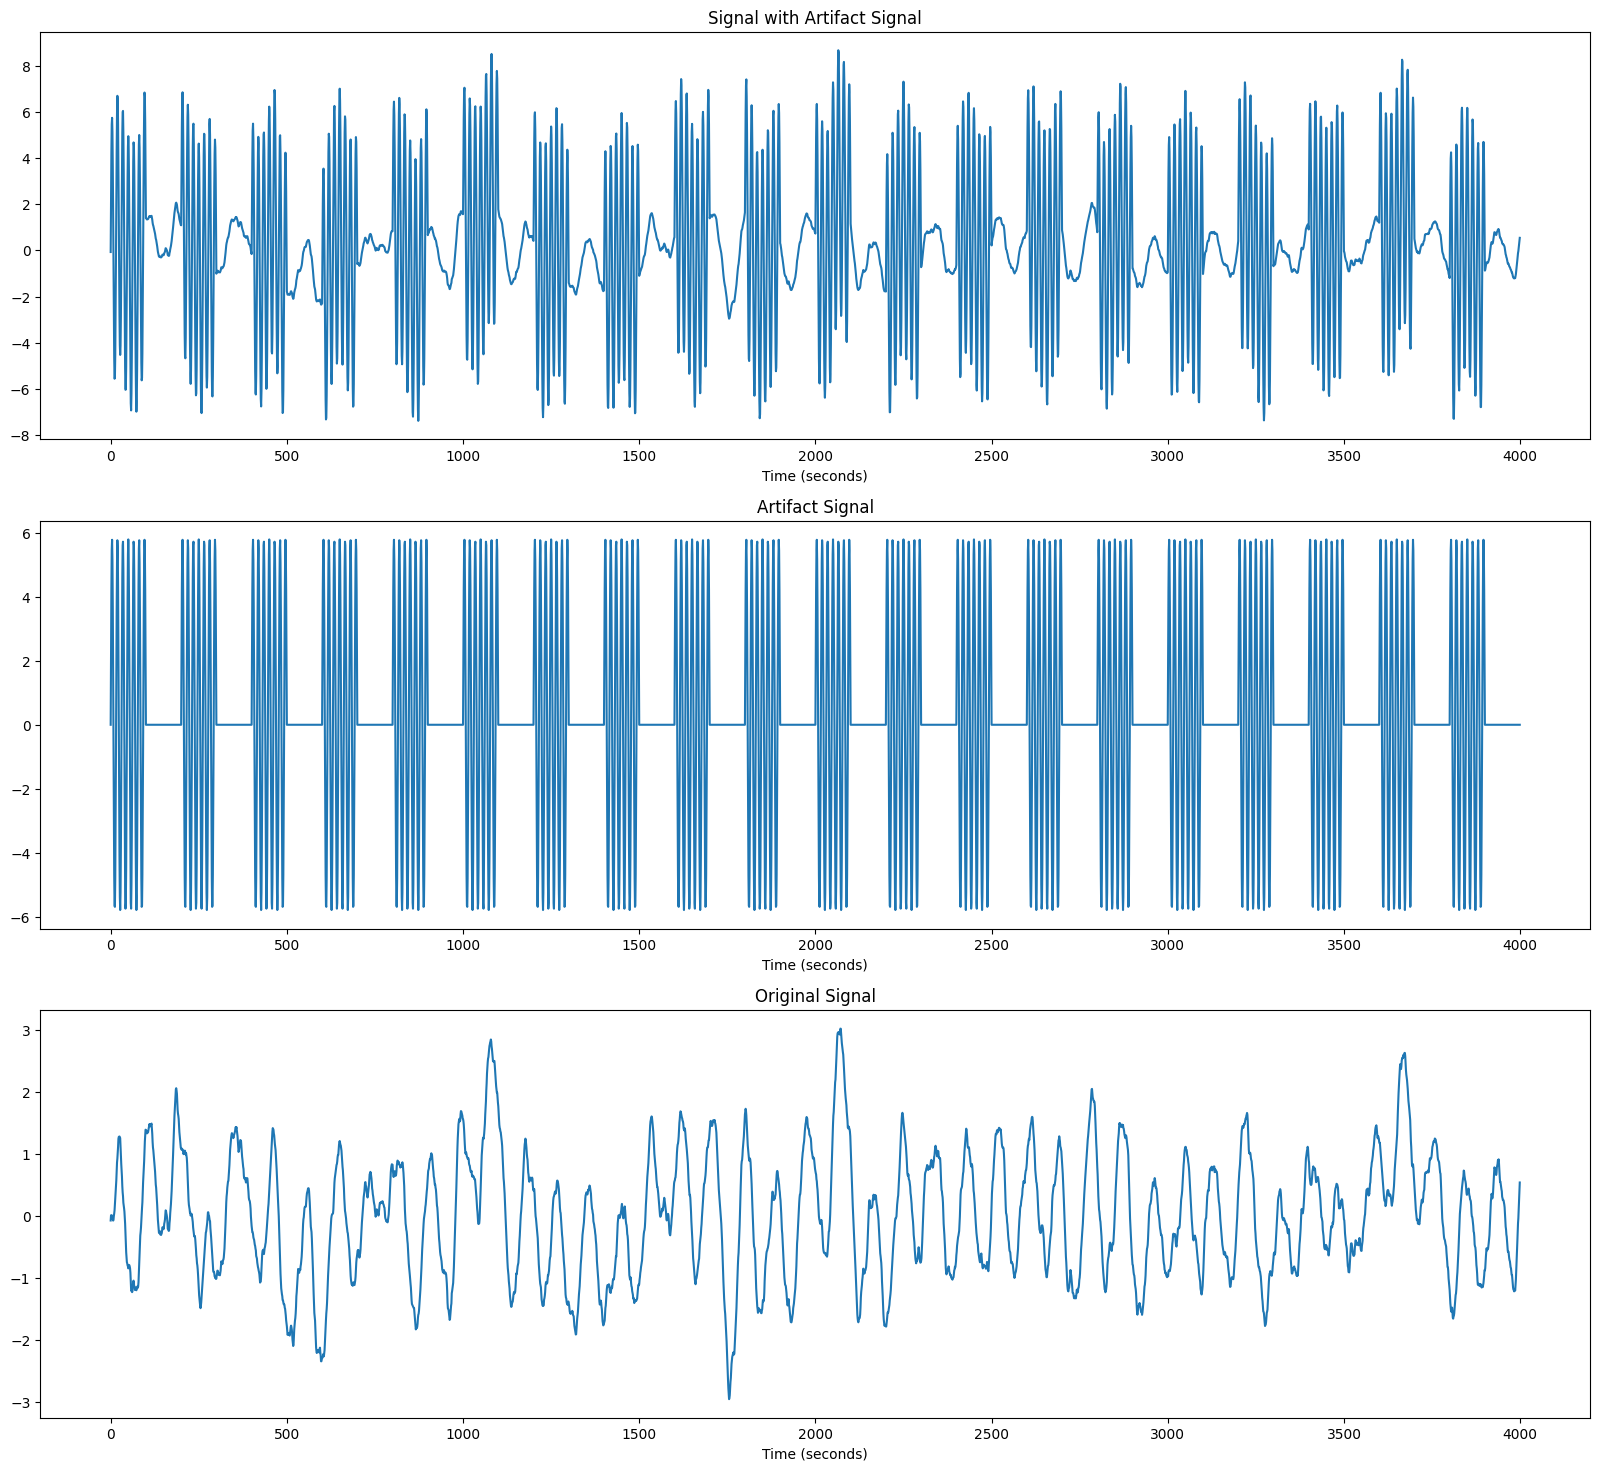

In [5]:
plt.figure(figsize=(20,18))
plt.subplot(3, 1, 1)
plt.plot(sig_with_artifact[0])
plt.xlabel("Time (seconds)")
plt.title('Signal with Artifact Signal')

plt.subplot(3, 1, 2)
plt.plot(artifact[0])
plt.xlabel("Time (seconds)")
plt.title('Artifact Signal')

plt.subplot(3, 1, 3)
plt.plot(sig[0])
plt.xlabel("Time (seconds)")
plt.title('Original Signal')

In [6]:
# MinMaxScaler를 이용하여 정규화
scaler = MinMaxScaler()
X = scaler.fit_transform(sig_with_artifact)
y = scaler.fit_transform(sig)

print(X.shape)
print(y.shape)

(1000, 4000)
(1000, 4000)


In [7]:
# Data preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape: {}, y_train shape: {}".format(X_train.shape, y_train.shape)) # x : B x T, y : B x T
print("X_test shape: {}, y_test shape: {}".format(X_test.shape, y_test.shape))

# 차원 추가 (CNN은 두번째 차원 추가)
X_train = X_train.reshape(X_train.shape[0], 1, 4000) # B x 1 x T
X_test = X_test.reshape(X_test.shape[0], 1, 4000)

print("unsqueezed X_train shape: {}, y_train shape: {}".format(X_train.shape, y_train.shape)) # x : B x 1 x T, y : B x T
print("unsqueezed X_test shape: {}, y_test shape: {}".format(X_test.shape, y_test.shape))

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

X_train shape: (800, 4000), y_train shape: (800, 4000)
X_test shape: (200, 4000), y_test shape: (200, 4000)
unsqueezed X_train shape: (800, 1, 4000), y_train shape: (800, 4000)
unsqueezed X_test shape: (200, 1, 4000), y_test shape: (200, 4000)


In [8]:
# 모델 정의
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, 3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(16, 1, 3, padding=1)
        
    def forward(self, x): # x : B x 1 x T
        x = self.relu(self.conv1(x)) # x : B x 16 x T
        x = self.conv2(x) # x : B x 1 x T
        x = x.squeeze(1) # x : B x T
        return x

model = CNN().to(device)
print(model)

CNN(
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (conv2): Conv1d(16, 1, kernel_size=(3,), stride=(1,), padding=(1,))
)


In [9]:
# 모델 훈련
learning_rate = 0.01
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 200

for epoch in range(num_epochs):
    for batch in train_loader:   
        x = batch[0] # x : B x 1 x T
        y = batch[1] # y : B x T
        x, y = x.to(device), y.to(device)
        
        y_pred = model(x) # y_pred : B x T
        loss = criterion(y_pred,y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1)%5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

Epoch 5/200, Loss: 0.0001036456014844589
Epoch 10/200, Loss: 7.403910421999171e-05
Epoch 15/200, Loss: 6.19017009739764e-05
Epoch 20/200, Loss: 5.296464587445371e-05
Epoch 25/200, Loss: 4.4618365791393444e-05
Epoch 30/200, Loss: 4.504798198468052e-05
Epoch 35/200, Loss: 4.212999192532152e-05
Epoch 40/200, Loss: 3.717010622494854e-05
Epoch 45/200, Loss: 3.735324207809754e-05
Epoch 50/200, Loss: 3.1789364584255964e-05
Epoch 55/200, Loss: 3.310363899799995e-05
Epoch 60/200, Loss: 2.9767328669549897e-05
Epoch 65/200, Loss: 2.4913610104704276e-05
Epoch 70/200, Loss: 2.3767466700519435e-05
Epoch 75/200, Loss: 1.9941422578995116e-05
Epoch 80/200, Loss: 1.5518251530011185e-05
Epoch 85/200, Loss: 1.219973182742251e-05
Epoch 90/200, Loss: 1.29747004393721e-05
Epoch 95/200, Loss: 1.2403081200318411e-05
Epoch 100/200, Loss: 9.076238711713813e-06
Epoch 105/200, Loss: 6.714258688589325e-06
Epoch 110/200, Loss: 7.556477157777408e-06
Epoch 115/200, Loss: 5.4206479944696184e-06
Epoch 120/200, Loss: 3.7

In [10]:
# 모델 평가
gt = torch.tensor([])
pred = torch.tensor([])

model.eval()
with torch.no_grad():
    for batch in test_loader:
        x = batch[0] # x : B x T x 1
        y = batch[1] # y : B x T
        x, y = x.to(device), y.to(device)
        
        y_pred = model(x) # y_pred : B x T

        pred = torch.cat((pred, y_pred.cpu()), 0)
        gt = torch.cat((gt, y.cpu()), 0)
    
val_loss = criterion(gt, pred)
print(f'Validation Loss: {val_loss.item():.4f}')    

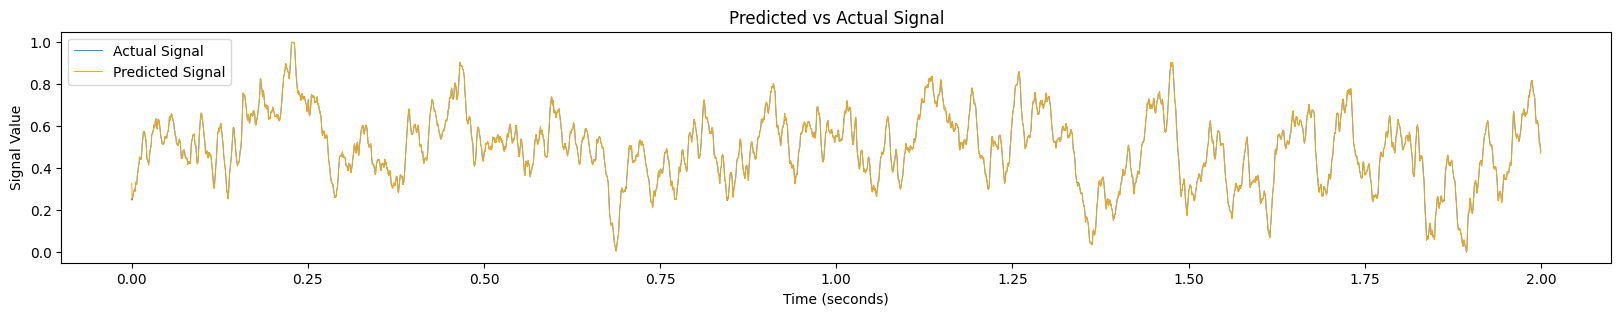

Mean Absolute Error: 0.0004837532469537109
Mean Squared Error: 1.878633725027612e-06


In [11]:
# time domain plotting

predicted_signal = pred[0]
actual_signal = gt[0]

t = np.linspace(0, 2, num=4000)  

plt.figure(figsize=(20, 3))
plt.plot(t, actual_signal, label='Actual Signal', color='dodgerblue', alpha=1, linewidth=0.7)
plt.plot(t, predicted_signal, label='Predicted Signal', color='orange', alpha=1, linewidth=0.7)
plt.xlabel('Time (seconds)')
plt.ylabel('Signal Value')
plt.title('Predicted vs Actual Signal')
plt.legend()
plt.show()

print(f"Mean Absolute Error: {mean_absolute_error(actual_signal, predicted_signal)}")
print(f"Mean Squared Error: {mean_squared_error(actual_signal, predicted_signal)}")

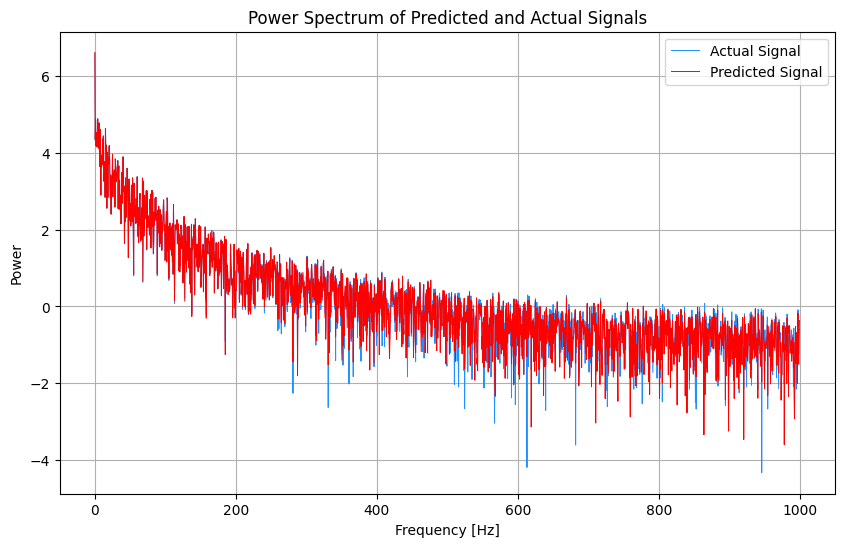

Mean Absolute Error: 0.16083338328843583
Mean Squared Error: 0.0763522047924198


In [12]:
# frequency domain plotting

n = len(predicted_signal)

fs = 2000
freqs = np.fft.fftfreq(n, d=1/fs)[:n//2]

fft_predicted = np.fft.fft(predicted_signal)
fft_predicted = np.abs(fft_predicted[:n//2])
fft_predicted[1:] = 2 * fft_predicted[1:]
power_predicted = fft_predicted**2

fft_actual = np.fft.fft(actual_signal)
fft_actual = np.abs(fft_actual[:n//2])
fft_actual[1:] = 2 * fft_actual[1:]
power_actual = fft_actual**2

# 결과 플로팅
plt.figure(figsize=(10, 6))
plt.plot(freqs, np.log10(power_actual), label='Actual Signal', color='dodgerblue', alpha=1, linewidth=0.7)
plt.plot(freqs, np.log10(power_predicted), label='Predicted Signal', color='red', alpha=1, linewidth=0.7)
plt.title('Power Spectrum of Predicted and Actual Signals')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.legend()
plt.grid(True)
plt.show()

print(f"Mean Absolute Error: {mean_absolute_error(np.log10(power_predicted), np.log10(power_actual))}")
print(f"Mean Squared Error: {mean_squared_error(np.log10(power_predicted), np.log10(power_actual))}")